In [1]:
! wget http://tdface.ece.tufts.edu/downloads/TD_IR_RGB_CROPPED/thermal-face-128x128/1-TD-A-4.jpg

--2020-12-07 19:41:58--  http://tdface.ece.tufts.edu/downloads/TD_IR_RGB_CROPPED/thermal-face-128x128/1-TD-A-4.jpg
Resolving tdface.ece.tufts.edu (tdface.ece.tufts.edu)... 130.64.23.35
Connecting to tdface.ece.tufts.edu (tdface.ece.tufts.edu)|130.64.23.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2348 (2.3K) [image/jpeg]
Saving to: ‘1-TD-A-4.jpg’

1-TD-A-4.jpg        100%[===================>]   2.29K  --.-KB/s    in 0s      

2020-12-07 19:41:58 (209 MB/s) - ‘1-TD-A-4.jpg’ saved [2348/2348]



In [2]:
! pip install scikit-image

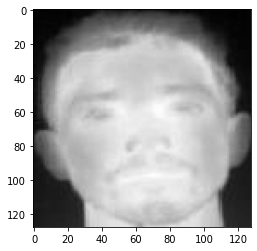

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('1-TD-A-4.jpg', 0)
img_plot = plt.imshow(img, cmap='gray')
plt.show()


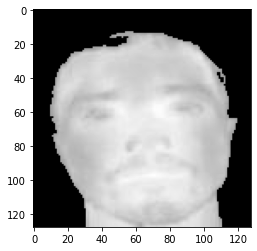

In [4]:
from skimage.filters import threshold_mean

thresh = threshold_mean(img)
th1 = img > thresh
th1 = th1.astype(np.uint8)

cropped_image = img*th1
plt.imshow(cropped_image, cmap='gray')
plt.show()


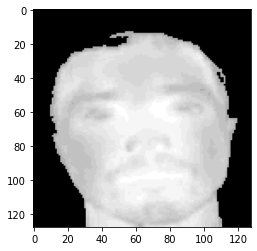

In [5]:
from sklearn import cluster
def km_clust(array, n_clusters):
    
    # Create a line array, the lazy way
    X = array.reshape((-1, 1))
    # Define the k-means clustering problem
    k_m = cluster.KMeans(n_clusters=n_clusters, n_init=4)
    # Solve the k-means clustering problem
    k_m.fit(X)
    # Get the coordinates of the clusters centres as a 1D array
    values = k_m.cluster_centers_.squeeze()
    # Get the label of each point
    labels = k_m.labels_
    return(values, labels)

# Group similar grey levels using 8 clusters
values, labels = km_clust(cropped_image, n_clusters = 10)
# Create the segmented array from labels and values
img_segm = np.choose(labels, values)
# Reshape the array as the original image
img_segm.shape = cropped_image.shape

plt.imshow(img_segm, cmap='gray')
plt.show()

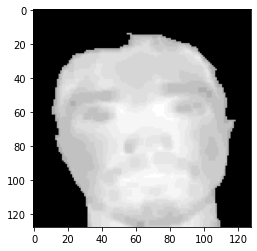

In [6]:
# Creating kernel 
kernel = np.ones((3, 3), np.uint8)
erode_face = cv2.erode(img_segm, kernel)
norm = cv2.normalize(erode_face, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img_plot = plt.imshow(norm, cmap='gray')
plt.show()

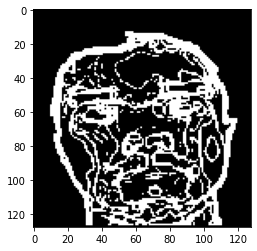

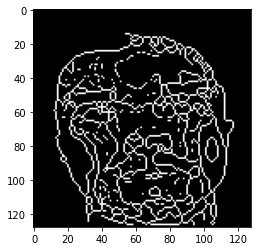

In [20]:
from skimage import filters

edge_sobel = filters.sobel(norm)
ret,thresh_img = cv2.threshold(edge_sobel,0.023,1,cv2.THRESH_BINARY)
vessels = thresh_img*th1 
img_plot = plt.imshow(vessels, cmap='gray')
plt.show()

from skimage.morphology import skeletonize

vessels = skeletonize(vessels, method='lee') # https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html
img_plot = plt.imshow(vessels, cmap='gray')
plt.show()


In [21]:
def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

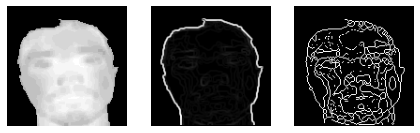

In [22]:
plot_images(erode_face, edge_sobel, vessels)

In [25]:
import numpy as np
import cv2
import skimage
import math

class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

def computeAngle(block, minutiaeType):
    (blkRows, blkCols) = np.shape(block)
    CenterX, CenterY = (blkRows-1)/2, (blkCols-1)/2
    angle = []
    if minutiaeType.lower() == 'termination':
        sumVal = 0
        for i in range(blkRows):
            for j in range(blkCols):
                if((i == 0 or i == blkRows-1 or j == 0 or j == blkCols-1) and block[i][j] != 0):
                    angle = -math.degrees(math.atan2(i-CenterY, j-CenterX))
                    sumVal += 1
                    if(sumVal > 1):
                        angle = float('nan');
        return angle
    elif minutiaeType.lower() == 'bifurcation':
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        angle = []
        sumVal = 0
        for i in range(blkRows):
            for j in range(blkCols):
                if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                    angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                    sumVal += 1
        if sumVal != 3:
            angle = float('nan')
        return angle


def extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif):
    FeaturesTerm = []

    minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeTerm)
    
    WindowSize = 2          # --> For Termination, the block size must can be 3x3, or 5x5. Hence the window selected is 1 or 2
    FeaturesTerm = []
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Termination')
        FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

    FeaturesBif = []
    minutiaeBif = skimage.measure.label(minutiaeBif, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeBif)
    WindowSize = 1          # --> For Bifurcation, the block size must be 3x3. Hence the window selected is 1
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Bifurcation')
        FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
    return FeaturesTerm, FeaturesBif


from google.colab.patches import cv2_imshow


def ShowResults(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0
    minutiaeTerm = BifLabel * 0

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel
    DispImg[:, :, 1] = skel
    DispImg[:, :, 2] = skel

    RP = skimage.measure.regionprops(BifLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))

    RP = skimage.measure.regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
        skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

    plt.imshow(DispImg)
    plt.show()





from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square

def getTerminationBifurcation(img, mask):
    img = img == 255
    (rows, cols) = img.shape
    minutiaeTerm = np.zeros(img.shape)
    minutiaeBif = np.zeros(img.shape)
    
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if img[i][j] == 1:
                block = img[i-1:i+2,j-1:j+2]
                block_val = np.sum(block);
                if(block_val == 2):
                    minutiaeTerm[i,j] = 1
                elif(block_val == 4):
                    minutiaeBif[i,j] = 1
    
    mask = convex_hull_image(mask>0)
    mask = erosion(mask, square(5))         # Structuing element for mask erosion = square(5)
    minutiaeTerm = np.uint8(mask)*minutiaeTerm
    return minutiaeTerm, minutiaeBif


def removeSpuriousMinutiae(minutiaeList, img, thresh):
    img = img * 0
    SpuriousMin = []
    numPoints = len(minutiaeList)
    D = np.zeros((numPoints, numPoints))
    for i in range(1,numPoints):
        for j in range(0, i):
            (X1,Y1) = minutiaeList[i]['centroid']
            (X2,Y2) = minutiaeList[j]['centroid']
            
            dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2)
            D[i][j] = dist
            if dist < thresh:
                SpuriousMin.append(i)
                SpuriousMin.append(j)
                
    SpuriousMin = np.unique(SpuriousMin)
    for i in range(0,numPoints):
        if i not in SpuriousMin:
            (X,Y) = np.int16(minutiaeList[i]['centroid'])
            img[X,Y] = 1;
    
    img = np.uint8(img);
    return img

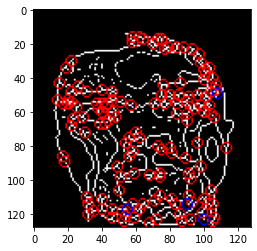

In [26]:
mask = vessels*255;
(minutiaeTerm, minutiaeBif) = getTerminationBifurcation(vessels, mask);

minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2);
RP = skimage.measure.regionprops(minutiaeTerm)
minutiaeTerm = removeSpuriousMinutiae(RP, np.uint8(img), 10);


BifLabel = skimage.measure.label(minutiaeBif, connectivity=2);
TermLabel = skimage.measure.label(minutiaeTerm, connectivity=2);

FeaturesTerm, FeaturesBif = extractMinutiaeFeatures(vessels, minutiaeTerm, minutiaeBif)

ShowResults(vessels, TermLabel, BifLabel)